Recipe for peak-fitting in a way that handles Bayesian block boundary effects

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

from xrdc import xrdutils
from xrdc import source_separation as sep
from xrdc import featurization as feat
from xrdc import visualization as vis
from xrdc import peak_fitting as pf
from xrdc import workflows
from xrdc import geometry
from xrdc import plotting
from xrdc import refinement
from xrdc import misc

from scipy.ndimage.filters import gaussian_filter as gf
from matplotlib.pyplot import figure

from copy import deepcopy as dc

Loading Data from: /home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/inputs/
Data Loaded Succesfully
(177, 800)
/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/dataproc/dataproc/workflows/basicConfig


In [2]:
basepath = "../../../datasets/nate/casettes/"

from glob import glob
import os

paths = glob(basepath + '*csv')

datasets = ([pd.read_csv(p) for p in paths])

In [3]:
threshold = 15
bg_smooth = 0
bg_smooth_post = 20

patterns = pd.DataFrame(d['I'] for d in datasets) * 1e1
patterns = patterns.values

background, fast_q, slow_T, fast_T = sep.separate_signal(patterns, background_after_filter = False,
                                 threshold = threshold, smooth_q = 1.7, smooth_neighbor_background = 0,
                                smooth_q_background = bg_smooth,
                                 bg_fill_method = 'simple')

(0, 0)


In [4]:
fast_q.mean()

343.53146313555226

In [5]:
N = len(patterns)
aggregate_uncertainty = np.sqrt((fast_T.std(axis = 0)**2 + background.std(axis = 0)**2) / N)
background = gf(background, (0, bg_smooth_post))
aggregate_uncertainty = gf(aggregate_uncertainty, bg_smooth_post)

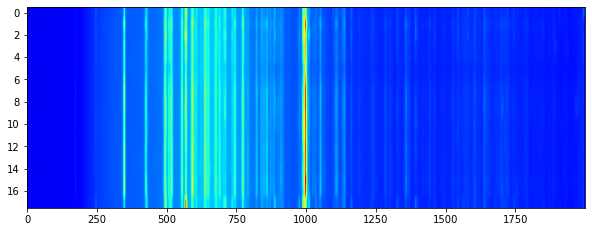

In [6]:
plt.imshow(patterns, aspect = 40, cmap = 'jet')

In [7]:
%matplotlib inline
sep.iplot_rows(patterns, fast_q, background, labels = ['raw', 'extracted'])

interactive(children=(IntSlider(value=8, description='i', max=17), Output(layout=Layout(height='550px'))), _do…

In [8]:
np.random.seed(42)
noise = aggregate_uncertainty[:, None].T


In [9]:
def mean2d(arr2d):
    return arr2d.mean(axis = 0)[:, None].T

In [10]:
def restrict_range(fitlists_merged, fitlists_single, offset = 1, clip = True):
    suby, _, noiseListNew, xListNew, yListNew, _ = fitlists_single
    _, summaryList, _, _, _, curve_paramsList = fitlists_merged
    
    def take(arr):
        if clip:
            return np.array(misc.deepmap(arr, lambda arr: arr[offset:-offset], 1))
        else:
            return np.array(arr)#misc.deepmap(arr, lambda arr: arr, 1))
    return suby, summaryList, take(noiseListNew), take(xListNew), take(yListNew), curve_paramsList


def filter_peaks_and_restrict_range(fitlists_merged, fitlists_single, bounds, offset = 1, clip_edges = True):
    filt = refinement.filter_peaks(fitlists_merged, bounds, 0, boundoffset = 1, buffer = 0.5, clip_edges = clip_edges)
    return restrict_range(filt, fitlists_single, clip = clip_edges)

In [52]:
stdratio_threshold = 6
pf.cfg['fitInfo']['numCurves'] = 4 # fit up to 4 curves per block
pf.cfg['fitInfo']['bba_norm'] = 100

background_agg = mean2d(background)[0]
patterns_agg = mean2d(patterns - 0)[0]

noise = aggregate_uncertainty[:, None].T
def curvefit_2d_refine(patterns, background, noise, overlap = 3, i = 0):
    # fit_sigma = True passes the estimated uncertainty to scipy.fit_curve
    patterns = patterns[None, :]
    background = background[None, :]
    fsub_stop_2d_1 = pf.curvefit_2d(patterns, stdratio_threshold = stdratio_threshold,\
                                    noise_estimate = noise, background = background,\
                                    bg_shift_pos = True, fit_sigma = True, reg_scale = 1e-1, reg_edge = 0);

    i, j = 0, 0
    x, y, X, Y, ys, bounds = pf.get_curves(fsub_stop_2d_1, 0, j, peak_range_only=False)

    fsub_stop_2d_1_filt = refinement.filter_peaks(fsub_stop_2d_1, bounds, 0, boundoffset = 0, buffer= .5,
                                                 clip_edges = False)

    return fsub_stop_2d_1, fsub_stop_2d_1_filt, bounds#, fsub_stop_2d_3_cropped

In [53]:
# reload(refinement.plotting)
# reload(plotting)
# reload(refinement)
# reload(pf.hitp)
# reload(pf)

* fits_init is the output of the multiple-peak-fitting procedure
* fits_filtered is produced by simply removing out-of-range peaks from fits_init

In [54]:
%%capture
fits_init, fits_filtered, bounds = curvefit_2d_refine(patterns_agg, background_agg, noise)

<IPython.core.display.Javascript object>


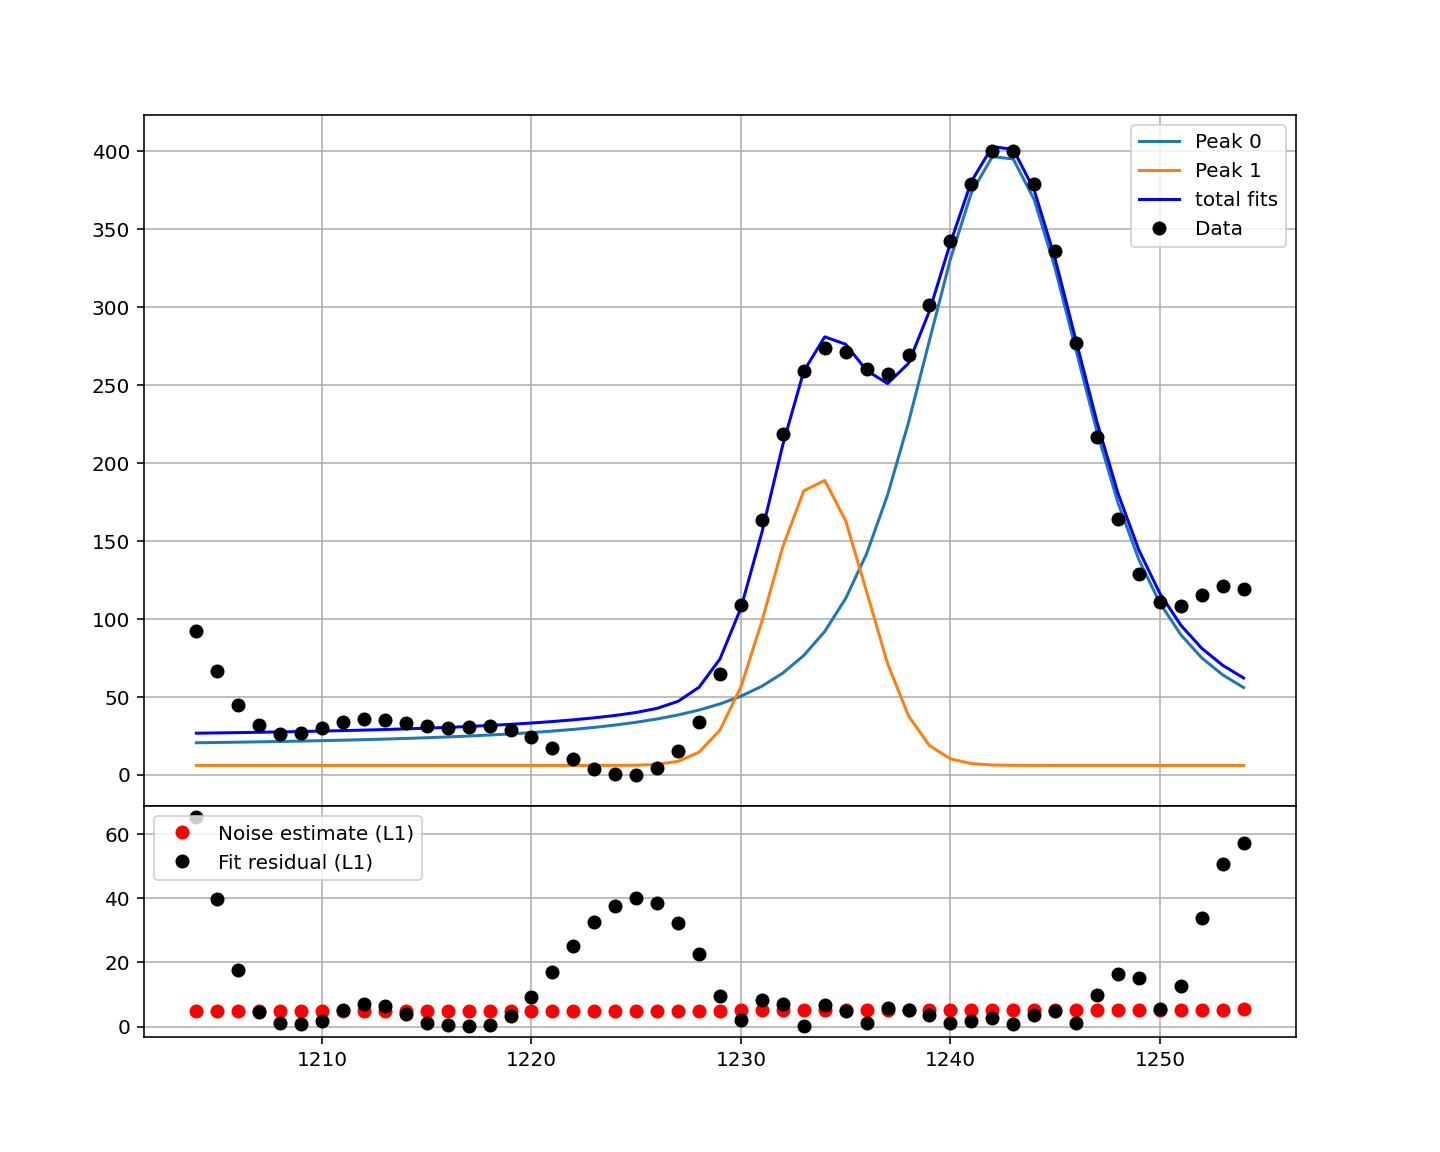

In [70]:
plotting.plot_one_fit(fits_init, 0, 32);

<IPython.core.display.Javascript object>


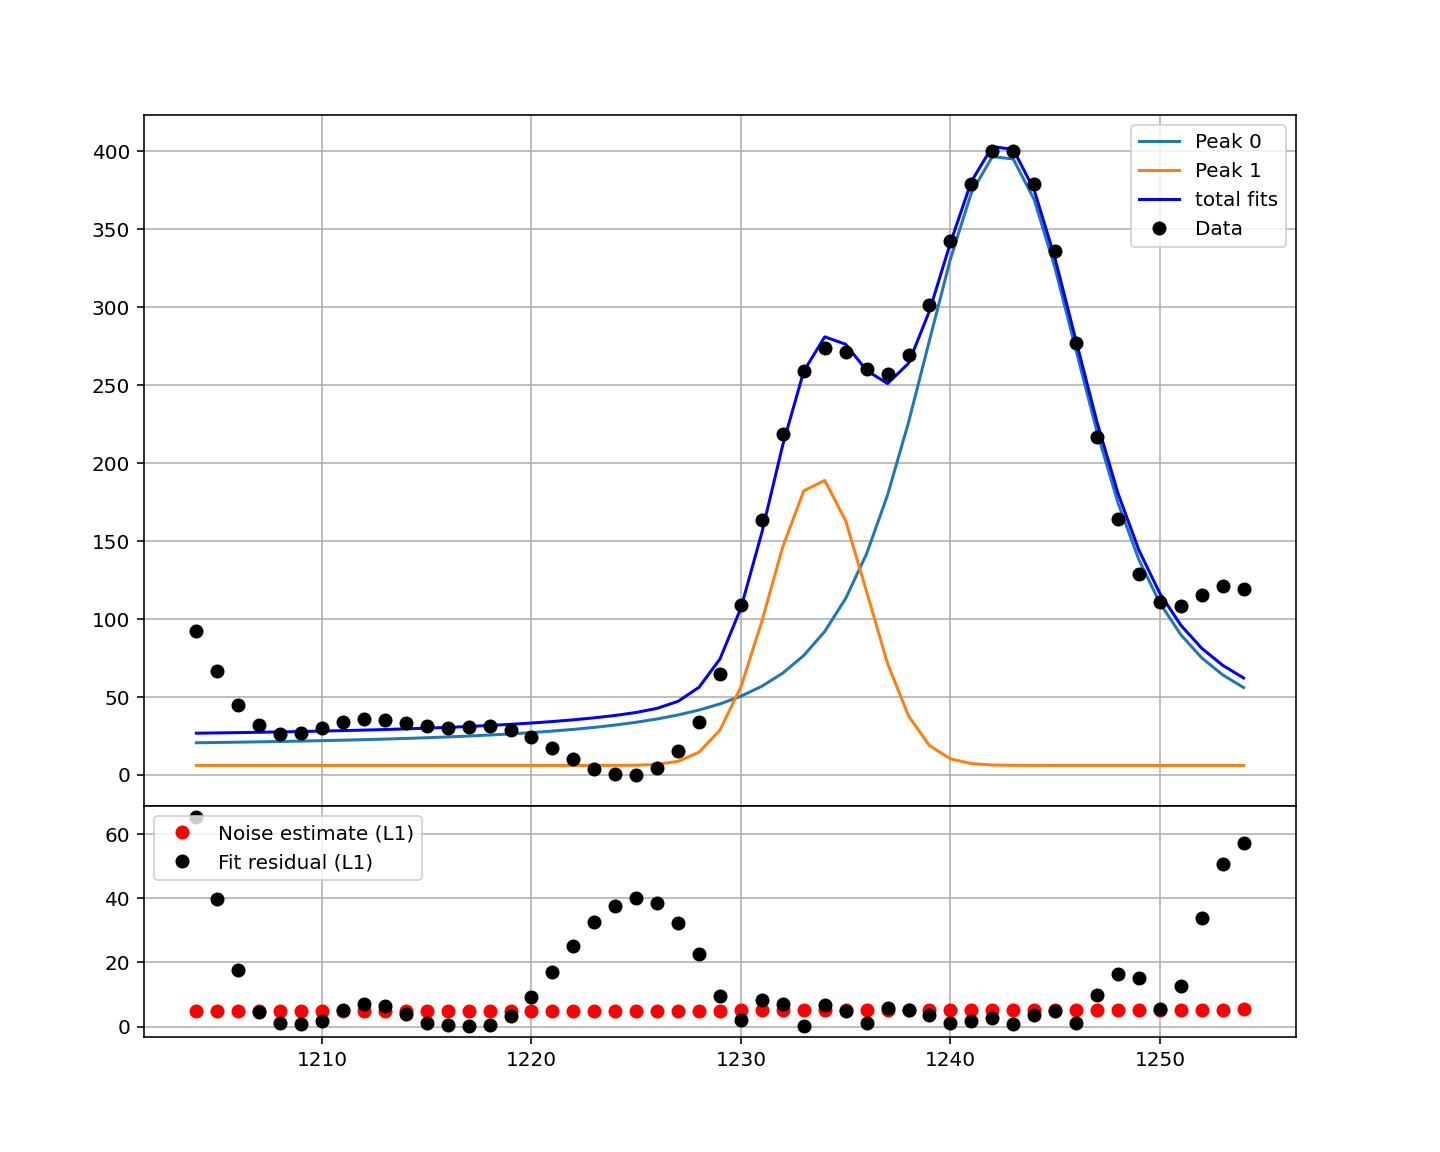

In [68]:
plotting.plot_one_fit(fits_filtered, 0, 32);

In [23]:
# XX, YY = refinement.get_tails(fsub_stop_2d_3, bounds, 0, 1, background = background)

<IPython.core.display.Javascript object>


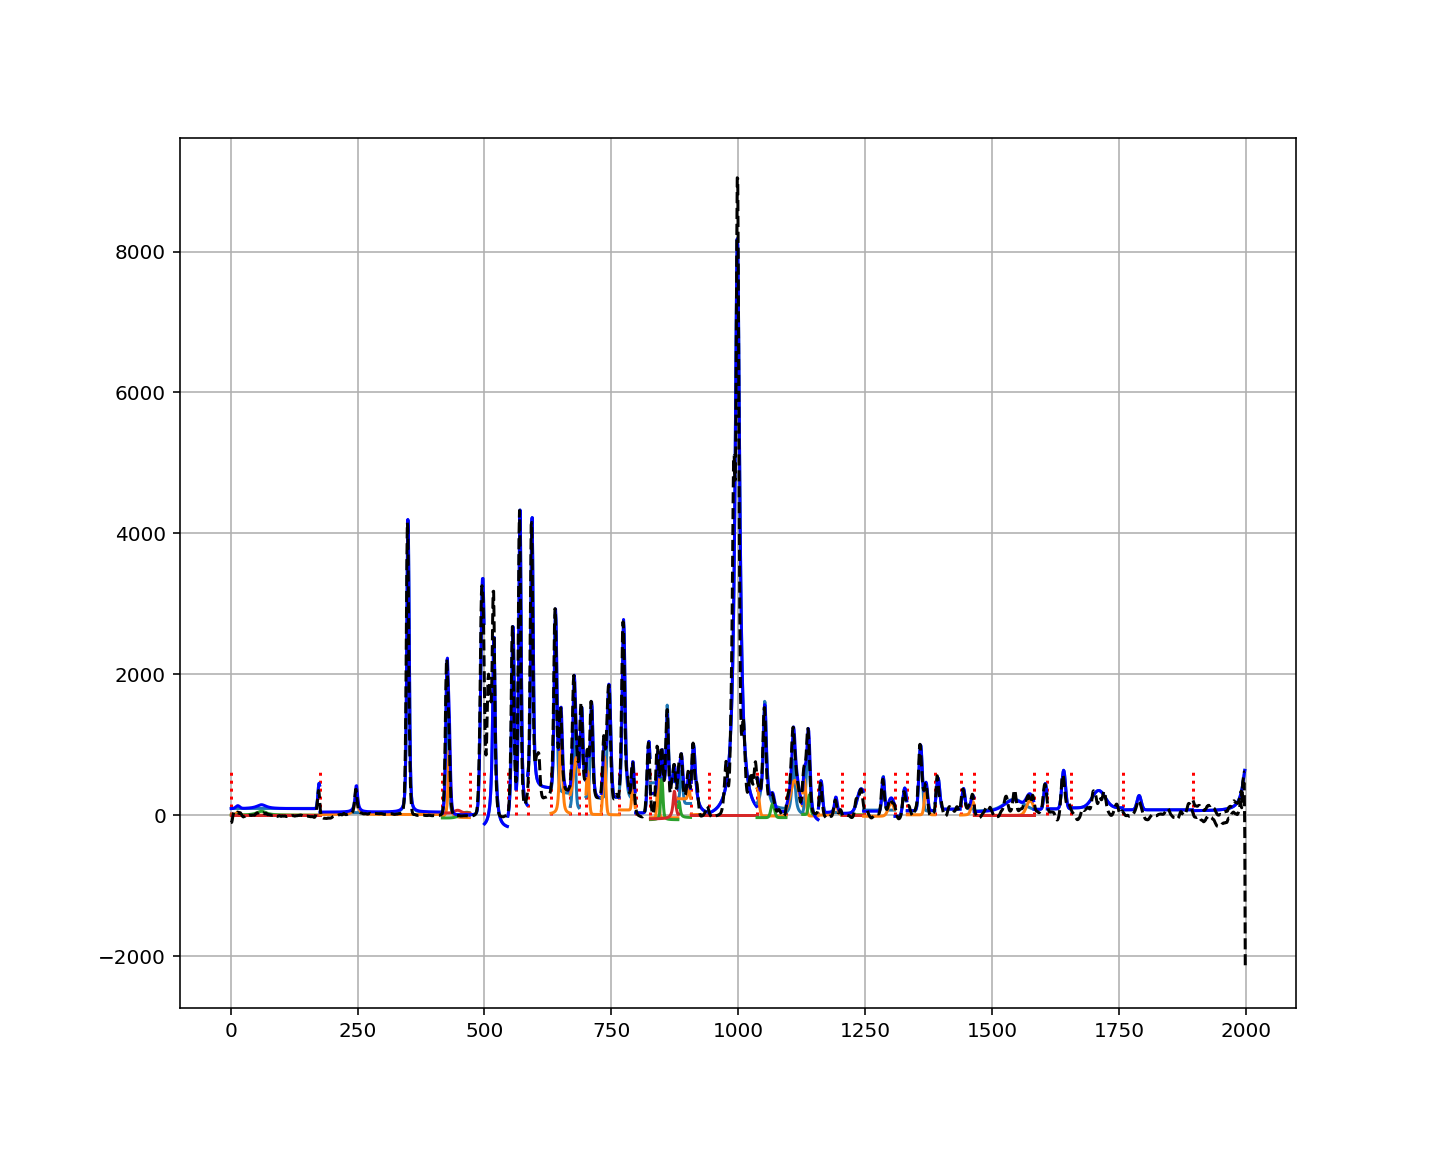

In [49]:
%matplotlib notebook
plotting.plot_all_fits(fits_filtered, 0);
plt.plot(mean2d(patterns - background)[0], 'k--')
#plt.plot(XX, YY, 'o')

<IPython.core.display.Javascript object>


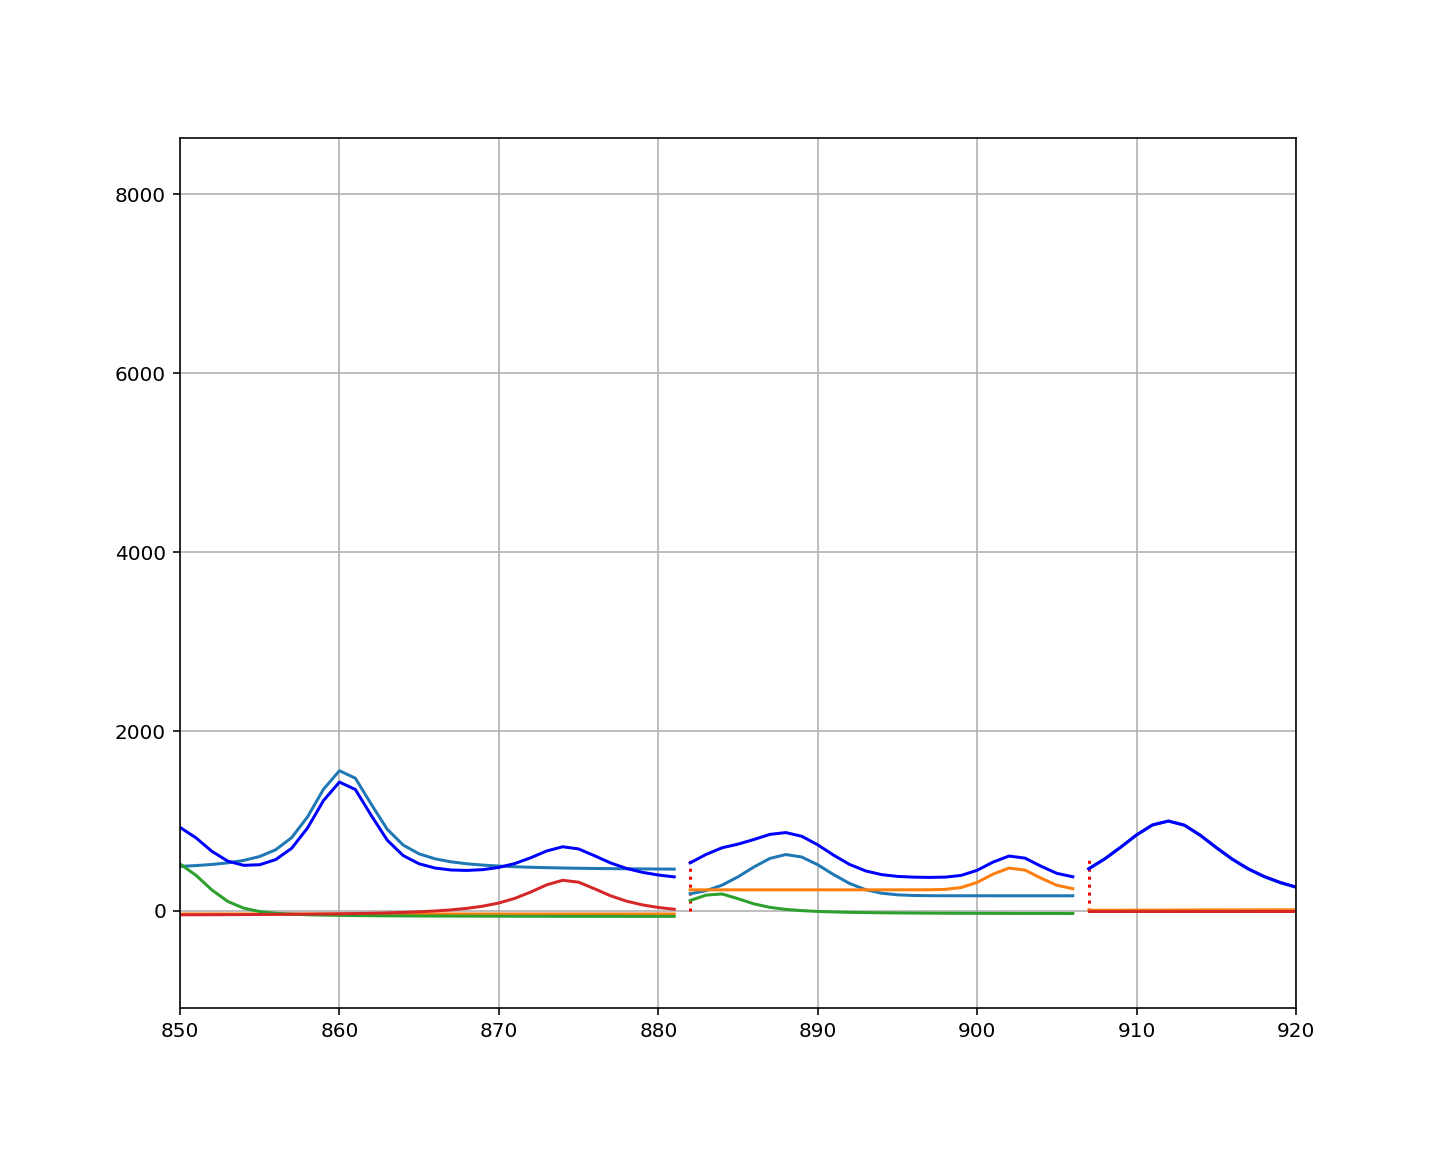

(850.0, 920.0)

In [48]:
plotting.plot_all_fits(fits_init, 0);
plt.xlim(850, 920)
#plt.ylim(-25, 200)

(-25.0, 200.0)

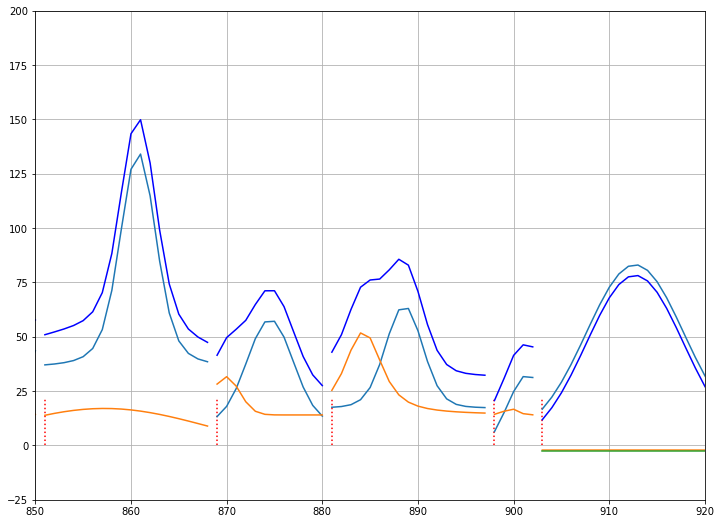

In [66]:
plotting.plot_all_fits(fits_refined, 0);
plt.xlim(850, 920)
plt.ylim(-25, 200)

In [64]:
def pad_fits(fits1, fits2, size = 1):
    def _padlist(lst1, lst2):
        return [lst2[:size]] + lst1 + [lst2[-size:]]
    res = [fits1[0]]
    for lst1, lst2 in zip(fits1[1:], fits2[1:]):
        res.append(_padlist(lst1, lst2))
    return res

# Interactive plots

interactive(children=(IntSlider(value=27, description='i', max=55), Output(layout=Layout(height='550px'))), _d…

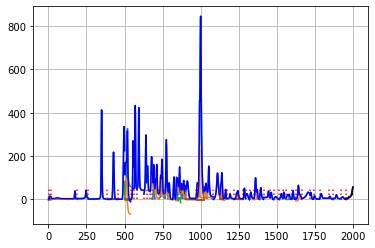

In [57]:
#40. add a difference plot
%matplotlib inline
Ys, yss = plotting.plot_all_fits(fits_init, 0);
sep.iplot_rows(yss, Ys,
               nested_label_callback= lambda lst, idx: 'curve '+ str(idx) if idx < (len(lst) - 1) else 'fit sum',
               styles = ['-', 'k--'],
               labels = ['', 'data (background subtracted)'])

interactive(children=(IntSlider(value=26, description='i', max=52), Output(layout=Layout(height='550px'))), _d…

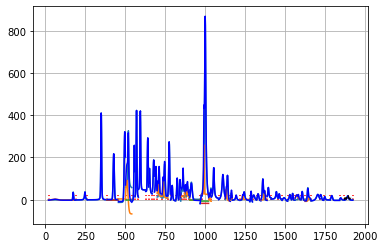

In [58]:
#40. add a difference plot
%matplotlib inline
Ys, yss = plotting.plot_all_fits(fits_refined, 0);
sep.iplot_rows(yss, Ys,
               nested_label_callback= lambda lst, idx: 'curve '+ str(idx) if idx < (len(lst) - 1) else 'fit sum',
               styles = ['-', 'k--'],
               labels = ['', 'data (background subtracted)'])